### Импорт библиотек

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Импорт библиотек для кластеризации
# Документация: https://scikit-learn.org/stable/modules/clustering.html
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram

In [3]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Библиотека для построения Self-Organizing Maps: sklearn-som
# Документация библиотеки: https://sklearn-som.readthedocs.io/en/latest/index.html

# ! python3.7 -m pip install sklearn-som
from sklearn_som.som import SOM

## Загрузка данных

In [5]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'baseball.sas7bdat'

In [6]:
# Загружаем данные из SAS файла
df = pd.read_sas(file_path, encoding='latin-1')
# Пример данных
df.head()

,Name,Team,nAtBat,nHits,nHome,nRuns,nRBI,nBB,YrMajor,CrAtBat,...,CrBB,League,Division,Position,nOuts,nAssts,nError,Salary,Div,logSalary
0,"Allanson, Andy",Cleveland,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,...,14.0,American,East,C,446.0,33.0,20.0,NaN,AE,NaN
1,"Ashby, Alan",Houston,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,...,375.0,National,West,C,632.0,43.0,10.0,475.0,NW,6.163315
2,"Davis, Alan",Seattle,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,...,263.0,American,West,1B,880.0,82.0,14.0,480.0,AW,6.173786
3,"Dawson, Andre",Montreal,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,...,354.0,National,East,RF,200.0,11.0,3.0,500.0,NE,6.214608
4,"Galarraga, Andres",Montreal,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,...,33.0,National,East,1B,805.0,40.0,4.0,91.5,NE,4.516339


## Формирование признакового пространства

In [7]:
# Сформируем признаковое пространство:
# 1. YrMajor - число лет в лиге
# 2. Признаки с префиксом "n" - результаты 1986 года 
# 3. Признаки с префиксом "сr"  - результаты за всю карьеру

results_1986 = [c for c in df.columns if c[0] == "n"]
results_all = [c for c in df.columns if c[:2] == "Cr"]
sign_features = ['YrMajor'] + results_1986 + results_all

In [9]:
# Стандартизация признаков
scaler = StandardScaler()
X = df.loc[:, sign_features]
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)
X.head()

,YrMajor,nAtBat,nHits,nHome,nRuns,nRBI,nBB,nOuts,nAssts,nError,CrAtBat,CrHits,CrHome,CrRuns,CrRbi,CrBB
0,-1.346261,-0.677078,-0.847808,-1.163177,-0.888041,-0.800135,-1.227600,0.560295,-0.540956,1.880899,-1.062463,-1.042700,-0.812788,-1.024958,-0.941912,-0.949467
1,1.273659,-0.523632,-0.507755,-0.472351,-1.127864,-0.446661,-0.040694,1.224058,-0.467771,0.308192,0.295038,0.133554,-0.056603,-0.158635,0.196252,0.371909
2,-0.943196,0.620240,0.603083,0.794164,0.550898,0.888687,1.715928,2.109075,-0.182349,0.937275,-0.489955,-0.444631,-0.123325,-0.447409,-0.241276,-0.038047
3,0.669062,0.738812,0.852454,1.024440,0.510928,1.124336,-0.135646,-0.317585,-0.701964,-0.792703,1.232299,1.265450,1.678172,1.350733,1.449712,0.295042
4,-1.144729,-0.481783,-0.371734,-0.126938,-0.528306,-0.289561,-0.467980,1.841429,-0.489727,-0.635432,-1.018159,-0.989165,-0.690464,-0.971371,-0.891656,-0.879920


## Часть 1: Иерархическая кластеризация и K-means

In [10]:
# Обучим модель Иерархической кластеризации
clustering = AgglomerativeClustering(compute_distances = True, distance_threshold = 0.0, n_clusters = None).fit(X)

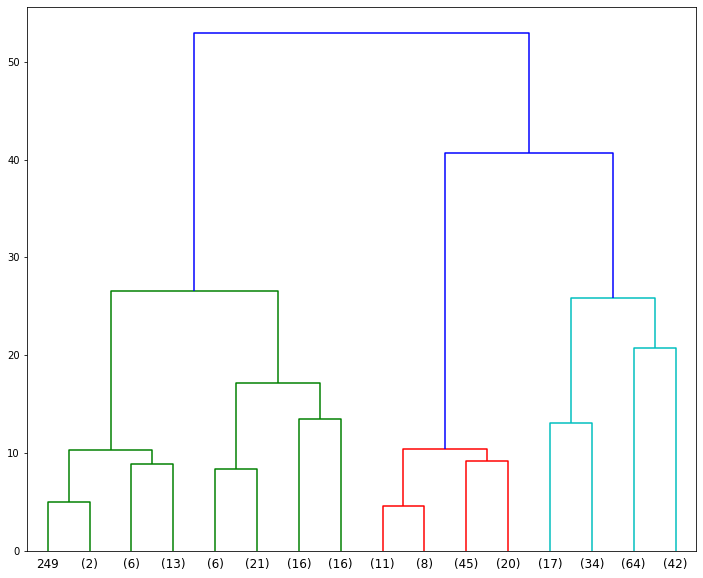

In [11]:
# Визуализация дендрограммы
def plot_dendrogram(model, **kwargs):
    # Создаем матрицу связности

    # Рассчитываем количество наблюдений в каждой вершине
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Лист
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    dendrogram(linkage_matrix, **kwargs, show_leaf_counts = True)

plot_dendrogram(clustering, truncate_mode="level", p=3)

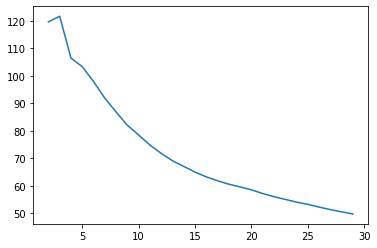

In [12]:
# Выберем число кластеров на основе псевдо критерия Фишера

def sum_dist_to_center(X):
    center = np.mean(X, axis = 0)
    return ((X - center)**2).values.sum()

def choose_num_clusters(X, max_clust = 30):
    N = X.shape[0]
    Q = sum_dist_to_center(X)
    pseudo_f = np.array([])
    for G in range(2, max_clust):
        clustering = AgglomerativeClustering(compute_distances = True, n_clusters = G).fit(X)
        W = 0
        for l in range(G):
            elems = X[clustering.labels_ == l]
            W += sum_dist_to_center(elems)
        fisher_stat = ((Q - W)/(G - 1))/(W/(N - G))
        pseudo_f = np.append(pseudo_f, fisher_stat)
    plt.plot(range(2, max_clust), pseudo_f)
    return np.argmax(pseudo_f)+2

k = choose_num_clusters(X)
clustering = KMeans(n_clusters=k, random_state=0).fit(X)
label = clustering.labels_

### Ответить на следующие вопросы:

#### 1.   Сколько кластеров было выбрано на основе псевдо критерия Фишера?
#### 2.   Используя информацию из графика, ответьте на вопросы:
> 1.   Каково значение критерия для выбранного числа кластеров?
> 2.   А для числа кластеров на один больше и на один меньше?



In [13]:
# Ответ на вопрос 1 - число кластеров
k

3

In [14]:
# Немного изменим функцию choose_num_clusters

def choose_num_clusters2(X, max_clust = 30):
    N = X.shape[0]
    Q = sum_dist_to_center(X)
    pseudo_f = np.array([])
    for G in range(2, max_clust):
        clustering = AgglomerativeClustering(compute_distances = True, n_clusters = G).fit(X)
        W = 0
        for l in range(G):
            elems = X[clustering.labels_ == l]
            W += sum_dist_to_center(elems)
        fisher_stat = ((Q - W)/(G - 1))/(W/(N - G))
        pseudo_f = np.append(pseudo_f, fisher_stat)
    return pseudo_f, np.argmax(pseudo_f)+2

pseudo_f, k  = choose_num_clusters2(X)

In [15]:
# Ответ на вопрос 2.1 - максимальное значение критерия
np.max(pseudo_f)

121.61624755184556

In [16]:
# это всё равно что
pseudo_f[k - 2]
# вычитаем 2, так как нумерация кластеров в массиве начинается с 2

121.61624755184556

In [17]:
# Ответ на вопрос 2.2 - значения критерия для 4 и 2 кластеров
pseudo_f[k - 1], pseudo_f[k - 3]

(106.4084884247154, 119.5692901945296)

## Часть 2: SOM

In [18]:
# Обучаем Self-Organizing Map с размером сетки 3 на 1
baseball_som = SOM(m=3, n=1, dim = X.shape[1])
baseball_som.fit(X.to_numpy())

labels = baseball_som.predict(X.to_numpy())

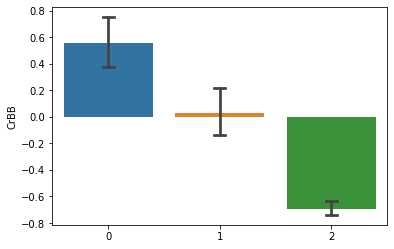

In [19]:
## Дополнительно #
## Значения признаков по кластерам удобно визуализировать с помощью barplot
## Нужное раскомментировать

## 1. В терминах matplotlib 
# plt.bar(labels, X["CrBB"])
# plt.ylabel("CrBB")
# plt.xlabel("cluster")

## 2. В терминах seaborn (+ доверительные интервалы)
sns.barplot(x = labels, y = X["CrBB"], capsize = 0.1)

## Часть 3: Анализ кластеров

## Построить модели:
> Для части 1: выбор количества кластеров на основе иерархической кластеризации с последующим обучение k-means

> Для части 2: обучение SOM с размером сетки 2 на 2 

## Ответить на следующие вопросы для каждой построенной модели
> Вариант I: Какой кластер содержит самых опытных игроков (переменная YrMajor)? 
> Вариант II: Какой кластер содержит самых успешных по хитам в 1986 году игроков (переменная nHits)?
> 1.	Сколько человек попало в этот кластер? 
> 2.    Как зовут самого типичного игрока в кластере вашего варианта (у него должно быть минимальное расстояние до центра вашего кластера)?

In [22]:
# Первая модель уже построена с тремя кластерами (в переменнаой clustering)
# Добавим в таблицу колонку с номерами кластеров
XX = X.copy()
XX['kmeans_label'] = clustering.predict(X)
# Выясним, в какие кластеры попали самые успешные игроки по nHits (сравниваем средние значения)
XX.groupby('kmeans_label').aggregate(np.mean).nHits
# Получаем кластер с номером 1 (у него максимальное среднее значение nHits)

kmeans_label
0    0.061666
1    0.919676
2   -0.791051
Name: nHits, dtype: float64

In [25]:
# Ответ на вопрос 1 - кол-во человек в кластере 1 для модели kmeans
sum(XX.kmeans_label == 1)

115

In [27]:
# Выберем элементы из кластера 1 и найдём его центроид
X1 = X[XX.kmeans_label == 1]
centroid = clustering.cluster_centers_[1]
# Находим индекс элемента с минимальным расстоянием до центроида
i = np.linalg.norm(X1 - centroid, axis=1).argmin()
# Выводим этот элемент
X1.iloc[i]

YrMajor   -0.137067
nAtBat     0.689988
nHits      0.625753
nHome      0.909302
nRuns      0.990574
nRBI       0.221013
nBB       -0.278075
nOuts      0.074963
nAssts    -0.716601
nError     0.150921
CrAtBat   -0.306288
CrHits    -0.303909
CrHome    -0.134446
CrRuns    -0.221153
CrRbi     -0.250145
CrBB      -0.440682
Name: 204, dtype: float64

In [28]:
# Ответ на вопрос 2 - имя типичного представителя кластера 1 для модели kmeans
df.iloc[X1.iloc[i].name].Name

'Davis, Mike'

In [37]:
# Построим модель SOM с размером сетки 2 на 2
baseball_som = SOM(m=2, n=2, dim = X.shape[1])
baseball_som.fit(X.to_numpy())
labels = baseball_som.predict(X.to_numpy())

In [38]:
# Далее всё аналогично
XX['SOM_label'] = labels
value = XX.groupby('SOM_label').aggregate(np.mean).nHits.argmax()
# Получаем номер кластера с самыми успешными игроками по nHits
value

3

In [39]:
# Ответ на вопрос 1 - кол-во человек в нашем кластере для модели SOM
sum(XX.SOM_label == value)

81

In [40]:
X_ = X[XX.SOM_label == value]
centroid = baseball_som.cluster_centers_.reshape(4, 16)[value]
i = np.linalg.norm(X_ - centroid, axis=1).argmin()
X_.iloc[i]

YrMajor   -0.338599
nAtBat    -0.014470
nHits     -0.009012
nHome      0.448751
nRuns      0.271105
nRBI      -0.093186
nBB       -0.040694
nOuts     -0.381820
nAssts    -0.716601
nError    -0.635432
CrAtBat   -0.253382
CrHits    -0.294731
CrHome     0.065721
CrRuns    -0.265809
CrRbi     -0.217626
CrBB      -0.319892
Name: 78, dtype: float64

In [41]:
# Ответ на вопрос 2 - имя типичного представителя кластера 1 для модели SOM
df.iloc[X_.iloc[i].name].Name

'Henderson, Dave'